<img src="https://cdn.bulbagarden.net/upload/2/21/001Bulbasaur.png" alt="Bulbasaur Pic" style="width: 256px;"/>

# Pokemon Image GAN

## Download from pkparaiso
See pokemon_img.sh for details. Run `chmod a+x ./pokemon_img.sh`, then `./pokemon_img.sh` to automatically setup directories, download and sort images, and install necessary tools. For the sudo commands to work this must be run on AWS or somewhere else where there is no sudo password prompt.

## Create GAN
When running as python script use the following commands.
1. `jupyter nbconvert --to script Pokemon_Img.ipynb --TemplateExporter.exclude_markdown=True --TemplateExporter.exclude_raw=True`
2.  `sudo python3 Pokemon_Img.py`

Uses standard DCGAN model architectures, but generator uses class-conditional noise vector (z is multiplied by embedding of L) and discriminator classifies images as both real/fake and by class. In this case, class will be pokemon type.

In [126]:
# import keras components
from keras import backend as K
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Embedding, Dropout, Multiply
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.preprocessing import image
from keras.optimizers import Adam
from keras.models import Model
from keras.utils.generic_utils import Progbar

K.set_image_dim_ordering('tf')

# import other tools
import numpy as np
from collections import defaultdict
from PIL import Image
import os, glob, pickle

np.random.seed(1337)

In [16]:
# compile generator model
def build_generator(noise_length):
    # we will map a pair of (z, L), where z is a latent noise vector and L is image class
    noise = Input(shape=(noise_length, ))
    image_class = Input(shape=(1,), dtype='int32')
    # 1 hot encode image class
    cls = Flatten()(Embedding(11, noise_length,
                    embeddings_initializer='glorot_normal')(image_class))
    # hadamard product between noise and a class embedding
    h = Multiply()([noise, cls])
    
    # DCGAN-like network
    G = Dense(1024, activation='relu')(h)
    G = Dense(8 * 8 * 128, activation='relu')(G)
    G = Reshape((8, 8, 128))(G)
    
    # upsample to 16 x 16
    G = UpSampling2D(size=(2, 2))(G)
    G = Conv2D(256, 3, padding='same',
        activation='relu', kernel_initializer='glorot_normal')(G)

    # upsample to 32 x 32
    G = UpSampling2D(size=(2, 2))(G)
    G = Conv2D(128, 3, padding='same',
        activation='relu', kernel_initializer='glorot_normal')(G)

    # upsample to 64 x 64
    G = UpSampling2D(size=(2, 2))(G)
    G = Conv2D(64, 3, padding='same',
        activation='relu', kernel_initializer='glorot_normal')(G)
    
    # upsample to 128 x 128
    G = UpSampling2D(size=(2, 2))(G)
    G = Conv2D(32, 3, padding='same',
        activation='relu', kernel_initializer='glorot_normal')(G)

    # take a channel axis reduction
    fake_image = Conv2D(3, 2, padding='same',
                        activation='tanh', kernel_initializer='glorot_normal')(G)

    return Model(inputs=[noise, image_class], outputs=fake_image)

In [104]:
# compile discriminator model
def build_discriminator():
    # standard conv net with LeakyReLUs
    image = Input(shape=(128, 128, 3))
    
    D = Conv2D(32, 3, padding='same', strides=2)(image)
    D = LeakyReLU()(D)
    D = Dropout(0.2)(D)

    D = Conv2D(64, 3, padding='same')(D)
    D = LeakyReLU()(D)
    D = Dropout(0.2)(D)

    D = Conv2D(128, 3, padding='same', strides=2)(D)
    D = LeakyReLU()(D)
    D = Dropout(0.3)(D)

    D = Conv2D(256, 3, padding='same')(D)
    D = LeakyReLU()(D)
    D = Dropout(0.2)(D)
    
    D = Conv2D(512, 3, padding='same', strides=2)(D)
    D = LeakyReLU()(D)
    D = Dropout(0.2)(D)
    D = Flatten()(D)
    
    # returns is_fake - whether discriminator thinks image is real or generated
    # and is_class - what class discriminator thinks image is in (as 1-hot-like vector)
    is_fake = Dense(1, activation='sigmoid', name='is_fake')(D)
    is_class = Dense(11, activation='softmax', name='is_class')(D)

    return Model(inputs=image, outputs=[is_fake, is_class])

In [121]:
# compile combined models

# batch and latent size taken from the paper
num_epochs = 50
batch_size = 128
noise_length = 100

# Adam parameters suggested in https://arxiv.org/abs/1511.06434
adam_lr = 0.0001
adam_beta_1 = 0.5

# build the discriminator
discriminator = build_discriminator()
discriminator.compile(
    optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
    loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
)

# build the generator
generator = build_generator(noise_length)
generator.compile(optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
                  loss='binary_crossentropy')

noise = Input(shape=(noise_length, ))
image_class = Input(shape=(1,), dtype='int32')

# get a fake image
fake_image = generator([noise, image_class])

# we only want to be able to train generation for the combined model
discriminator.trainable = False
is_fake, is_class = discriminator(fake_image)
combined = Model(inputs=[noise, image_class], outputs=[is_fake, is_class])

combined.compile(
    optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
    loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
)
print(combined.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_44 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_45 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
model_26 (Model)                (None, 128, 128, 3)  9184175     input_44[0][0]                   
                                                                 input_45[0][0]                   
__________________________________________________________________________________________________
model_25 (Model)                [(None, 1), (None, 1 3141452     model_26[1][0]                   
Total para

## Train GAN
1. Load data set from files
2. Train generator and discriminator on each batch of images
3. Every epoch, print losses, save weights, and generator sample file

In [122]:
data_dir = '/home/ubuntu/fastai-data/pokemon_img'
train_path = os.path.join(data_dir, 'train')
temp_path = os.path.join(data_dir, 'temp')
result_path = os.path.join(data_dir, 'results')

```
# get our mnist data, and force it to be of shape (..., 28, 28, 1) with range [-1, 1]
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)

X_test = (X_test.astype(np.float32) - 127.5) / 127.5
X_test = np.expand_dims(X_test, axis=3)

num_train, num_test = X_train.shape[0], X_test.shape[0]

train_history = defaultdict(list)
test_history = defaultdict(list)
```

In [123]:
def get_batches(dirname, temp_dir=None, shuffle=True, batch_size=batch_size):
    gen = image.ImageDataGenerator(preprocessing_function=lambda x: (x - 127.5) / 127.5,
                                  horizontal_flip=True,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  zoom_range=[1.0, 1.35])
    return gen.flow_from_directory(dirname,
                                  target_size=(128,128),
                                  class_mode='categorical',
                                  color_mode='rgb',
                                  shuffle=shuffle,
                                  save_to_dir=temp_dir,
                                  batch_size=batch_size)

batches = get_batches(train_path, batch_size=110)
print(batches.class_indices)

batch, labels = next(batches)
print('mean: {} std dev: {}'.format(np.mean(batch), np.std(batch)))

num_images = sum([len(files) for r, d, files in os.walk(train_path)])
train_history = defaultdict(list)
test_history = defaultdict(list)

Found 64024 images belonging to 11 classes.
{'Metal': 8, 'Lightning': 7, 'Fire': 5, 'Fairy': 3, 'Darkness': 1, 'Psychic': 9, 'Colorless': 0, 'Grass': 6, 'Water': 10, 'Fighting': 4, 'Dragon': 2}
mean: 0.761629581451416 std dev: 0.46442511677742004


In [112]:
generator.load_weights(sorted(
    glob.glob(os.path.join(result_path, 'params_generator*')))[-1])
discriminator.load_weights(sorted(
    glob.glob(os.path.join(result_path, 'params_discriminator*')))[-1])

In [ ]:
for epoch in range(num_epochs):
    print('Epoch {} of {}'.format(epoch + 1, num_epochs))

    num_batches = int(num_images / batch_size)
    progress_bar = Progbar(target=num_batches)

    epoch_gen_loss = []
    epoch_disc_loss = []

    for batch_num in range(num_batches):
        progress_bar.update(batch_num)
        # generate a new batch of noise
        noise_batch = np.random.uniform(-1, 1, (batch_size, noise_length))

        # get a batch of real images
        image_batch, label_onehot = next(batches)
        label_batch = np.argmax(label_onehot, axis=1)
        
        # sample some labels from p_c
        sampled_labels = np.random.randint(0, 11, batch_size)

        # generate a batch of fake images, using the generated labels as a
        # conditioner. We reshape the sampled labels to be
        # (batch_size, 1) so that we can feed them into the embedding
        # layer as a length one sequence
        generated_images = generator.predict(
            [noise_batch, sampled_labels.reshape((-1, 1))], verbose=0)

        X = np.concatenate((image_batch, generated_images))
        y = np.array([1] * len(image_batch) + [0] * batch_size)
        aux_y = np.concatenate((label_batch, sampled_labels), axis=0)

        # see if the discriminator can figure itself out...
        epoch_disc_loss.append(discriminator.train_on_batch(X, [y, aux_y]))

        # make new noise. we generate 2 * batch size here such that we have
        # the generator optimize over an identical number of images as the
        # discriminator
        noise_batch = np.random.uniform(-1, 1, (2 * batch_size, noise_length))
        sampled_labels = np.random.randint(0, 11, 2 * batch_size)

        # we want to train the genrator to trick the discriminator
        # For the generator, we want all the {fake, not-fake} labels to say
        # not-fake
        trick = np.ones(2 * batch_size)

        epoch_gen_loss.append(combined.train_on_batch(
            [noise_batch, sampled_labels.reshape((-1, 1))], [trick, sampled_labels]))

    '''
    print('\nTesting for epoch {}:'.format(epoch + 1))

    # generate a new batch of noise
    noise_batch = np.random.uniform(-1, 1, (num_test, noise_length))

    # sample some labels from p_c and generate images from them
    sampled_labels = np.random.randint(0, 10, num_test)
    generated_images = generator.predict(
        [noise_batch, sampled_labels.reshape((-1, 1))], verbose=False)

    X = np.concatenate((X_test, generated_images))
    y = np.array([1] * num_test + [0] * num_test)
    aux_y = np.concatenate((y_test, sampled_labels), axis=0)

    # see if the discriminator can figure itself out...
    discriminator_test_loss = discriminator.evaluate(
        X, [y, aux_y], verbose=False)

    # make new noise
    noise_batch = np.random.uniform(-1, 1, (2 * num_test, noise_length))
    sampled_labels = np.random.randint(0, 10, 2 * num_test)

    trick = np.ones(2 * num_test)

    generator_test_loss = combined.evaluate(
        [noise_batch, sampled_labels.reshape((-1, 1))],
        [trick, sampled_labels], verbose=False)

    '''
    discriminator_train_loss = np.mean(np.array(epoch_disc_loss), axis=0)
    generator_train_loss = np.mean(np.array(epoch_gen_loss), axis=0)

    # generate an epoch report on performance
    train_history['generator'].append(generator_train_loss)
    train_history['discriminator'].append(discriminator_train_loss)

    test_history['generator'].append(generator_train_loss)
    test_history['discriminator'].append(discriminator_train_loss)

    print('{0:<22s} | {1:4s} | {2:15s} | {3:5s}'.format(
        'component', *discriminator.metrics_names))
    print('-' * 65)

    ROW_FMT = '{0:<22s} | {1:<4.2f} | {2:<15.2f} | {3:<5.2f}'
    print(ROW_FMT.format('generator (train)',
                         *train_history['generator'][-1]))
    print(ROW_FMT.format('generator (test)',
                         *test_history['generator'][-1]))
    print(ROW_FMT.format('discriminator (train)',
                         *train_history['discriminator'][-1]))
    print(ROW_FMT.format('discriminator (test)',
                         *test_history['discriminator'][-1]))

    # save weights every epoch
    generator.save_weights(os.path.join(result_path,
        'params_generator_epoch_{0:02d}.hdf5'.format(epoch)), True)
    discriminator.save_weights(os.path.join(result_path,
        'params_discriminator_epoch_{0:02d}.hdf5'.format(epoch)), True)

    # generate some digits to display
    noise_batch = np.random.uniform(-1, 1, (100, noise_length))

    sampled_labels = np.array([
        [i] * 10 for i in range(11)
    ]).reshape(-1, 1)

    # get a batch to display
    generated_images = generator.predict(
        [noise_batch, sampled_labels], verbose=0)

    # arrange them into a grid
    img = (np.concatenate([r.reshape(-1, 128, 3)
        for r in np.split(generated_images, 10)
        ], axis=1) * 127.5 + 127.5).astype(np.uint8)

    Image.fromarray(img).save(os.path.join(result_path,
        'plot_epoch_{0:03d}_generated.png'.format(epoch)))
    
    # dump history
    pickle.dump({'train': train_history, 'test': test_history},
        open(os.path.join(result_path, 'acgan-history.pkl'), 'wb'))

Epoch 1 of 50
  0/500 [..............................] - ETA: 0s

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


340/500 [===================>..........] - ETA: 9:29

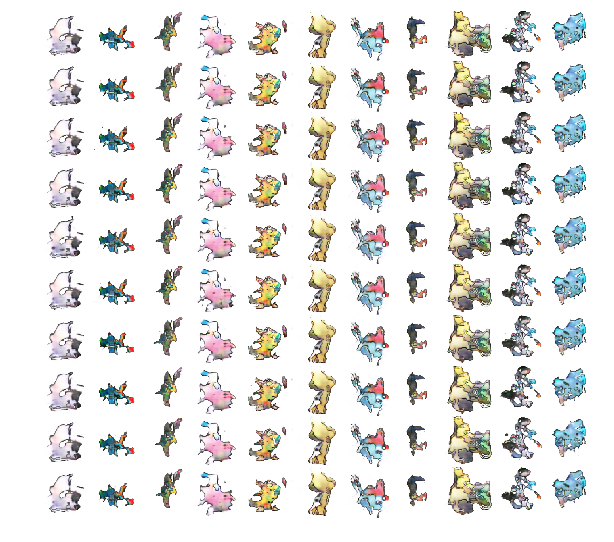

In [101]:
from keras.preprocessing import image
from matplotlib import pyplot as plt
import numpy as np
import random, os

# Instantiate plotting tool
%matplotlib inline

np.random.seed(17)

# generate some digits to display
noise_batch = np.random.uniform(-1, 1, (110, noise_length))

sampled_labels = np.array([
    [i] * 10 for i in range(11)
]).reshape(-1, 1)

# get a batch to display
generated_images = generator.predict(
    [noise_batch, sampled_labels], verbose=0)

# arrange them into a grid
img = (np.concatenate([r.reshape(1280, 128, 3)
    for r in np.split(generated_images, 11)
    ], axis=1) * 127.5 + 127.5).astype(np.uint8)

plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(img)
plt.show()
# Colorless, Darkness, Dragon, Fairy, Fighting, Fire, Grass, Lightning, Metal, Psychic, Water